In [1]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

In [16]:
industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv('Data/us-retail-sales.csv',parse_dates=['Month'],index_col='Month',usecols=['Month']+industries).to_period('D').reindex(columns=industries)
retail.head()

,BuildingMaterials,FoodAndBeverage
Month,,
1992-01-01,8964,29589
1992-02-01,9023,28570
1992-03-01,10608,29682
1992-04-01,11630,30228
1992-05-01,12327,31677


In [22]:
retail = pd.concat({'Sales':retail},names=[None,'Industries'],axis=1)
retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

In [23]:
y = retail.copy()

In [24]:
# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()
X.head()

,const,trend,trend_squared
Month,,,
1992-01-01,1.0,1.0,1.0
1992-02-01,1.0,2.0,4.0
1992-03-01,1.0,3.0,9.0
1992-04-01,1.0,4.0,16.0
1992-05-01,1.0,5.0,25.0


In [25]:
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)

In [29]:
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [30]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [31]:
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

/tmp/ipykernel_8143/4171025953.py:3: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
/tmp/ipykernel_8143/4171025953.py:4: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit.plot(color='blue', subplots=True, sharex=True, ax=axs)
/tmp/ipykernel_8143/4171025953.py:5: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred.plot(color='red', subplots=True, sharex=True, ax=axs)


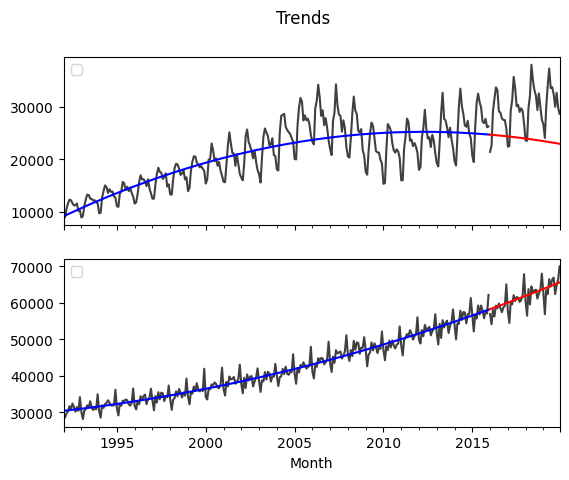

In [32]:
# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='blue', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='red', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [33]:
retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

In [44]:
retail.stack().pop('Sales')

Month       Industries       
1992-01-01  BuildingMaterials     8964
            FoodAndBeverage      29589
1992-02-01  BuildingMaterials     9023
            FoodAndBeverage      28570
1992-03-01  BuildingMaterials    10608
                                 ...  
2019-10-01  FoodAndBeverage      64849
2019-11-01  BuildingMaterials    29793
            FoodAndBeverage      66363
2019-12-01  BuildingMaterials    28621
            FoodAndBeverage      70028
Name: Sales, Length: 672, dtype: int64

In [56]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')  # grab target series
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

In [57]:
X.head()

,Industries
Month,
1992-01-01,BuildingMaterials
1992-01-01,FoodAndBeverage
1992-02-01,BuildingMaterials
1992-02-01,FoodAndBeverage
1992-03-01,BuildingMaterials


In [64]:
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

In [66]:
X.head()

,Industries
Month,
1992-01-01,0
1992-01-01,1
1992-02-01,0
1992-02-01,1
1992-03-01,0


In [67]:
# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12
X.head()

,Industries,Month
Month,,
1992-01-01,0,1
1992-01-01,1,1
1992-02-01,0,2
1992-02-01,1,2
1992-03-01,0,3


In [68]:
# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [69]:
X_train.head()

,Industries,Month
Month,,
1992-01-01,0,1
1992-01-01,1,1
1992-02-01,0,2
1992-02-01,1,2
1992-03-01,0,3


In [72]:
y_fit.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01       9192.966040    30384.413252
1992-02-01       9324.354900    30430.803516
1992-03-01       9455.202650    30477.545559
1992-04-01       9585.509289    30524.639380
1992-05-01       9715.274818    30572.084979

In [73]:
y_fit.stack().head()

Sales
Month      Industries                     
1992-01-01 BuildingMaterials   9192.966040
           FoodAndBeverage    30384.413252
1992-02-01 BuildingMaterials   9324.354900
           FoodAndBeverage    30430.803516
1992-03-01 BuildingMaterials   9455.202650

In [80]:
y_train

Month       Industries       
1992-01-01  BuildingMaterials     8964
            FoodAndBeverage      29589
1992-02-01  BuildingMaterials     9023
            FoodAndBeverage      28570
1992-03-01  BuildingMaterials    10608
                                 ...  
2015-10-01  FoodAndBeverage      57692
2015-11-01  BuildingMaterials    26075
            FoodAndBeverage      57099
2015-12-01  BuildingMaterials    26232
            FoodAndBeverage      62185
Name: Sales, Length: 576, dtype: int64

In [81]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

/tmp/ipykernel_8143/2192305118.py:5: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.unstack(['Industries']).plot(
/tmp/ipykernel_8143/2192305118.py:8: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit_boosted.unstack(['Industries']).plot(
/tmp/ipykernel_8143/2192305118.py:11: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred_boosted.unstack(['Industries']).plot(


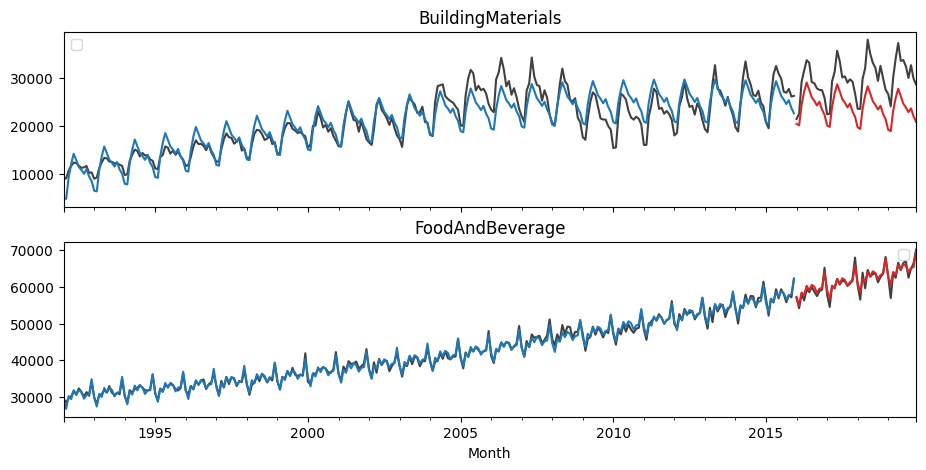

In [82]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])